In [26]:
import numpy as np
import matplotlib.pyplot as plt
import math

# Definir las constantes
g = 9.8 # gravedad [m/s^2]
p_atm = 101325 # Presión atmosférica [Pa]
beta = 3.67e-3 # Coeficiente de expansion termica [1/K]
T_w = 80.0 + 273.0 # Temperatura de la pared [K]
T_a = 20.0 + 273.0 # Temperatura ambiente [K]
delta_T = T_w - T_a
lambda_f = 0.04 # Coeficiente de friccion [adimensional]
R = 10.0 # Radio de la tuberia [m]
L = 100.0 # Longitud de la tuberia [m]
D = 2 * R
alpha = 2.2e-5 # Coeficiente de difusividad [m^2/s]
rho_0 = 1.0 # Densidad [kg/m^3]
Cp = 1.012 # Capacidad calorifica [J/(kg K)]
k = 0.024 # Conductividad termica [W/(m K)]
nu = 1.71e-5 # Viscosidad [Pa s]
h = 1.42 * (delta_T/L)**(1/4) # coeficiente de transmision de calor por convección (recopilatorio)

print(f'Número de Rayleigh: {Ra_D:.2e}\n'
      f'h: {h:.2e}')


Número de Rayleigh: 5.90e+13
h: 1.25e+00


In [27]:
phi = 1/ (beta * delta_T)
Ri = 2 * rho_0**2 * g * beta * L * Cp**2 * delta_T /  h**2 # Numero de Richardson
Ra = rho_0**2 * g * beta * Cp * D**2 * delta_T / (16 * nu * h) # Numero de Rayleigh
LAMBDA = L/D # Relación de aspecto
delta = alpha * h / (L**2 * rho_0 * g * beta * Cp * delta_T)

print(f'Numero de Richardson: {Ri:.2e} \nNumero de Rayleigh: {Ra:.2e} \nphi: {phi:.4f}')

# Para tener un flujo laminar el numero de Rayleigh tienen que ser menor que 1e9

Numero de Richardson: 2.83e+02 
Numero de Rayleigh: 2.55e+06 
phi: 4.5413


In [33]:
def f(v, phi, Ri, Ra, LAMBDA):
    return phi + Ri**-1 * v**2 + Ra**-1 * v - 1 + (v/LAMBDA) * (1 - math.exp(-LAMBDA/v))

def f_prime(v, Ri, Ra, LAMBDA):
    return 2 * Ri**-1 * v + Ra**-1 + (1/LAMBDA) * (1 - (1 + 1/v)*math.exp(-LAMBDA/v))

def newton_raphson(phi, Ri, Ra, LAMBDA, v0=0.1, tol=1e-6, max_iter=100):
    v = v0
    for i in range(max_iter):
        v_new = v - f(v, phi, Ri, Ra, LAMBDA) / f_prime(v, Ri, Ra, LAMBDA)
        if abs(v_new - v) < tol:
            return v_new, i+1
        v = v_new
    return v  # Returns the last approximation if it doesn't converge


print(f'Numero de Richardson: {Ri:.2e} \nNumero de Rayleigh: {Ra:.2e} \nphi: {phi:.4f} \nLambda: {LAMBDA:.2f}')
v_0 = newton_raphson(phi, Ri, Ra, LAMBDA)
print(f"Solution: v_e = {v_0:.6f}")

v_e = v_0


Numero de Richardson: 2.83e+02 
Numero de Rayleigh: 2.55e+06 
phi: 4.5413 
Lambda: 5.00
Solution: v_e = 7.241852


El valor de theta cuando eta = 1 es: 0.4986


<>:35: SyntaxWarning: invalid escape sequence '\e'
<>:35: SyntaxWarning: invalid escape sequence '\e'
/var/folders/lx/vhxvbgp94fj63r8wrldf_13m0000gn/T/ipykernel_1615/2843251638.py:35: SyntaxWarning: invalid escape sequence '\e'
  '''# Marcar el punto (1, theta_1) en la gráfica


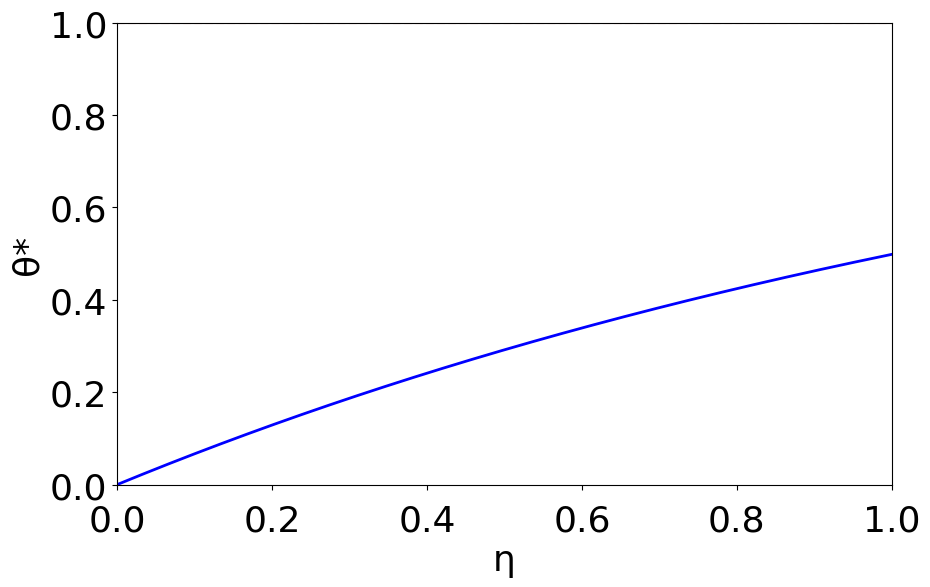

In [29]:
def theta_estrella(eta, LAMBDA, v_e):
    a = LAMBDA / v_e
    return 1 - np.exp(-a * eta)

# Crear un rango de valores para eta
eta = np.linspace(0, 1, 1000)  # Ajusta el rango según sea necesario

# Calcular theta_estrella para cada valor de eta
theta = theta_estrella(eta, LAMBDA, v_e)

# Calcular theta cuando eta = 1
eta_1 = 1
theta_1 = theta_estrella(eta_1, LAMBDA, v_e)

# Calculo de la temperatura en K
T_f = delta_T * theta_1 + T_a

a = LAMBDA/ v_e

print(f"El valor de theta cuando eta = 1 es: {theta_1:.4f}")

# Crear la gráfica
plt.figure(figsize=(10, 6))
plt.plot(eta, theta, 'b-', linewidth=2)
#plt.title(f'Gráfica de θ* = 1 - e^(-{a:.4f}η)')
plt.xlabel('η', fontsize = 26)
plt.ylabel('θ*', fontsize = 26)
#plt.grid(True)
plt.axhline(y=1, color='r', linestyle='--', alpha=0.5)  # Línea asintótica en y=1
plt.xlim(0, max(eta))
plt.ylim(0, 1)
plt.tick_params(axis='both', which='major', labelsize=26)
plt.tick_params(axis='x', which='major', pad=10)

'''# Marcar el punto (1, theta_1) en la gráfica
plt.plot(1, theta_1, 'ro', markersize=10)  # 'ro' significa un punto rojo
plt.annotate(r'$\theta^* (\eta = 1) = $' + f'{theta_1:.4f}' + f', $T_f$ = {T_f-273:.2f} ºC', xy=(1, theta_1), xytext=(1.2, theta_1),
             arrowprops=dict(facecolor='black', shrink=0.005))
'''
# Añadir una ecuación en la gráfica
#plt.text(0.5, 0.2, f'θ* = 1 - e^(-{a:.4f}η)', fontsize=12, bbox=dict(facecolor='white', alpha=0.5))

plt.show()

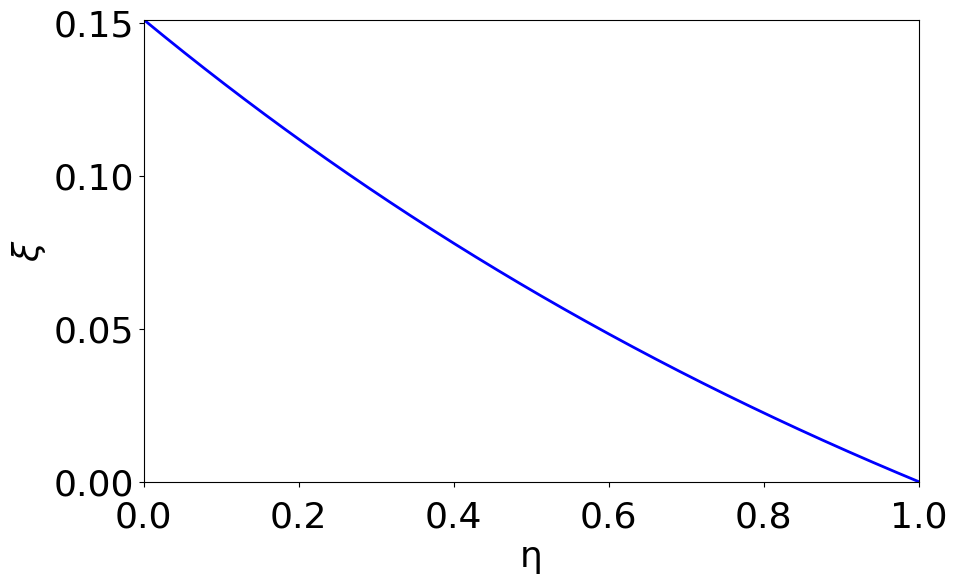

In [30]:
def xi_fun(eta, v_e, Ra, phi, LAMBDA):
    return v_e**2 / (Ra * phi) * (1 - eta) - LAMBDA / (phi * v_e) * (1 - np.exp(-(LAMBDA/v_e) * (eta - 1)))

# Crear un rango de valores para eta
eta = np.linspace(0, 1, 1000)  # Ajusta el rango según sea necesario

# Calcular theta_estrella para cada valor de eta
xi_dist = xi_fun(eta, v_e, Ra, phi, LAMBDA)

# Crear la gráfica
plt.figure(figsize=(10, 6))
plt.plot(eta, xi_dist, 'b-', linewidth=2)
#plt.title(f'Gráfica de ' + r'$\xi$ vs η en estacionario')
plt.xlabel('η', fontsize = 26)
plt.ylabel(r'$\xi$', fontsize = 26)
#plt.grid(True)
#plt.axhline(y=1, color='r', linestyle='--', alpha=0.5)  # Línea asintótica en y=1
plt.xlim(0, max(eta))
plt.ylim(0, max(xi_dist))
plt.tick_params(axis='both', which='major', labelsize=26)
plt.tick_params(axis='x', which='major', pad=10)

# Añadir una ecuación en la gráfica
#plt.text(0.5, 0.2, f'θ* = 1 - e^(-{a:.4f}η)', fontsize=12, bbox=dict(facecolor='white', alpha=0.5))

plt.show()

In [31]:
# Definición de variables y condiciones iniciales
M = 256 # Número de puntos en la dirección vertical
N = 512 # Número de puntos en la dirección temporal
eta = np.linspace(0, 1, M)  # Coordenada vertical adimensional
tau = np.linspace(0, 1, N)  # Coordenada temporal adimensional
deta = (eta[-1] - eta[0])/M
dtau = (tau[-1] - tau[0])/N 
v = np.zeros(N)  # Velocidad adimensional
theta_star = np.zeros((M, N))  # Temperatura adimensional
xi = np.zeros((M, N))  # Presión adimensional, inicialmente todo el espacio se encuentra a p_atm

# Condiciones iniciales
v[0] = 0.0  # Velocidad inicial cero
theta_star[:, 0] = 0.0   #Temperatura inicial uniforme
xi[:, 0] = 0.0 #Diferencia de presión entre el interior del tubo y el exterior

# Simulación numérica

for t in range(1, N-1):
    # Calculo de la velocidad en el instante i+1 a partir de la presión en eta = 0 del instante anterior:
    v[t] = np.sqrt(-Ri * phi * xi[0, t-1])

    # Calculo de las distribuciones de temperatura y presion en el espacio para el instante i+1:
    for x in range(1, M-1):
        dtheta_deta = (theta_star[x+1, t-1] - theta_star[x-1, t-1]) / (2 * deta)
        d2theta_deta2 = (theta_star[x+1, t-1] - 2 * theta_star[x, t-1] + theta_star[x-1, t-1]) / deta**2
        theta_star[x, t] = theta_star[x, t-1] - dtau * (2 * Ri**-1 * v_e * v[t] * dtheta_deta
                                            - delta * d2theta_deta2
                                            + 2 * Ri**-1 * LAMBDA * (theta_star[x, t-1] - 1))
    
    # Cálculo de xi
    dxi_deta = np.zeros(M)
    for x in range(1, M-1):
        dtheta_deta = (theta_star[x+1, t] - theta_star[x-1, t]) / (2 * deta)
        dxi_deta[x] = (1/phi) * dtheta_deta
    
    # Integramos dxi_deta para obtener xi
    xi[:, t] = np.cumsum(dxi_deta) * deta
    
    # Ajustamos xi para que xi[0, t] = 0 (condición de contorno)
    xi[:, t] -= xi[0, t]

    # Cálculo de la nueva v usando la ecuación proporcionada
    dxi_deta_0 = (xi[1, t] - xi[0, t]) / deta  # Aproximación de la derivada en eta = 0
    dv_dtau = -phi/v_e * dxi_deta_0 - Ra**-1 * v[t-1] + theta_star[1, t]/v_e
    v[t] = v[t-1] + dv_dtau * dtau
        

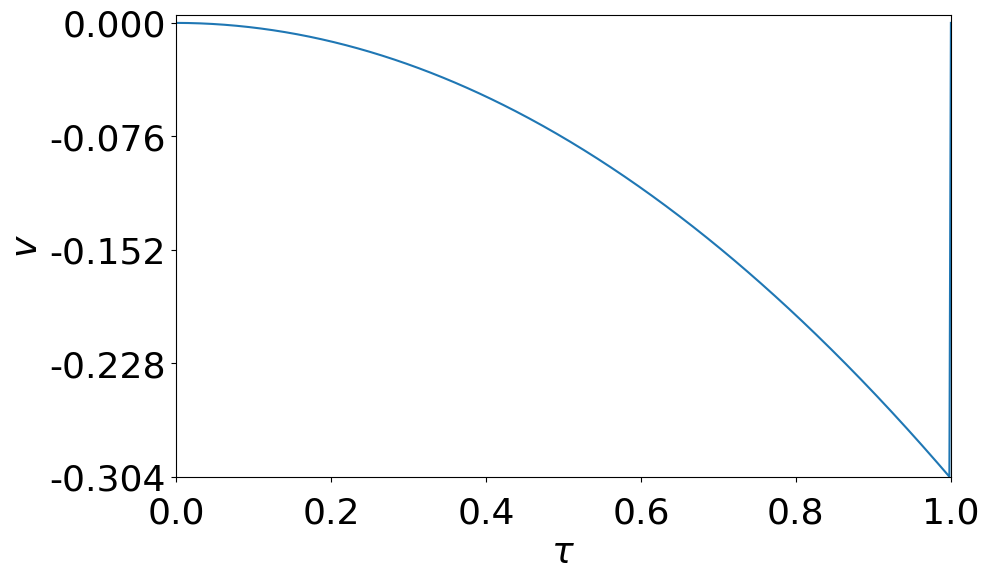

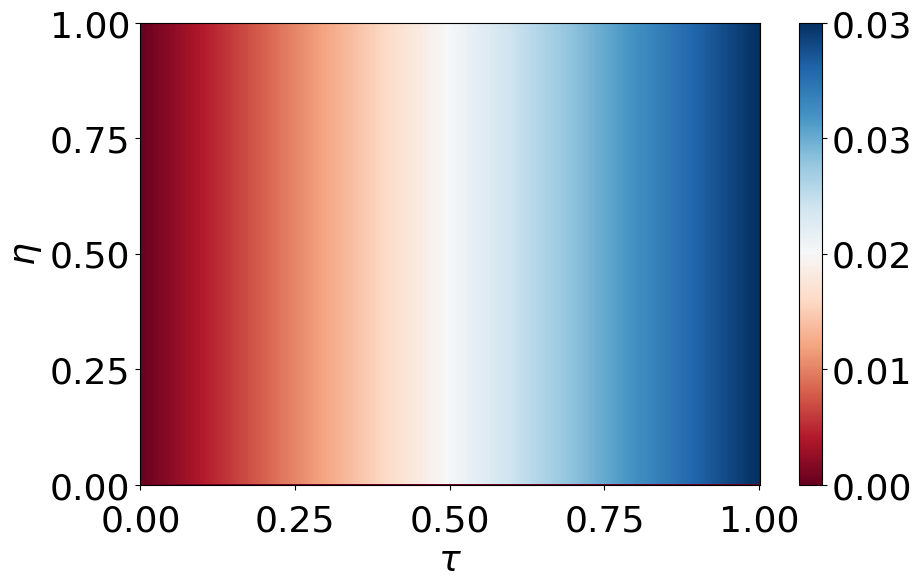

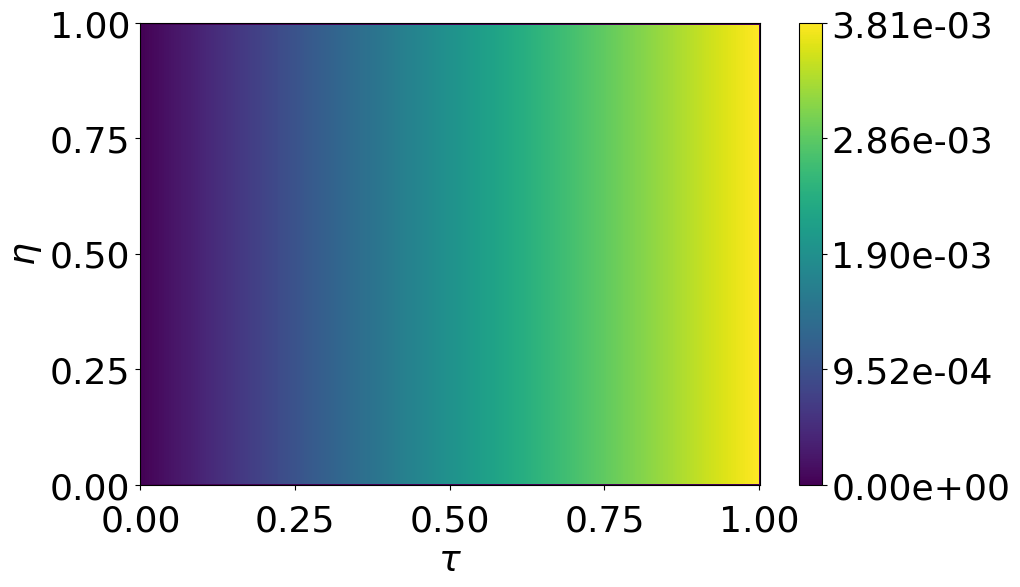

In [32]:
from matplotlib.ticker import FormatStrFormatter

# Gráfico lineal de v
plt.figure(figsize=(10, 6))
plt.plot(tau, v)
plt.xlabel(r'$\tau$', fontsize=26)
plt.ylabel(r'$v$', fontsize=26)
plt.xlim(0,1)
plt.ylim(0,0.0055)
plt.tick_params(axis='both', which='major', labelsize=26)
plt.tick_params(axis='x', which='major', pad=10)

# Modificar el número de ticks y formato en el eje y
y_ticks = np.linspace(min(v), max(v), 5)  # 5 ticks equidistantes
plt.yticks(y_ticks)
plt.gca().yaxis.set_major_formatter(FormatStrFormatter('%.3f'))  # 3 decimales

plt.show()

# Mapa de calor de θ*
plt.figure(figsize=(10, 6))
im = plt.pcolormesh(tau, eta, theta_star, cmap='RdBu')
cbar = plt.colorbar(im)
plt.xlabel(r'$\tau$', fontsize=26)
plt.ylabel(r'$\eta$', fontsize=26)
plt.ylim(0,1)
plt.tick_params(axis='both', which='major', labelsize=26)
plt.tick_params(axis='x', which='major', pad=10)

# Modificar el número de ticks y formato en el eje y
y_ticks = np.linspace(min(eta), max(eta), 5)  # 5 ticks equidistantes
plt.yticks(y_ticks)
plt.gca().yaxis.set_major_formatter(FormatStrFormatter('%.2f'))  # 2 decimales

# Modificar el número de ticks y formato en la barra de color
cbar.set_ticks(np.linspace(np.min(theta_star), np.max(theta_star), 5))
cbar.formatter = FormatStrFormatter('%.2f')  # 2 decimales
cbar.ax.tick_params(labelsize=26)
cbar.update_ticks()

plt.show()

# Mapa de calor de xi (presiones)
plt.figure(figsize=(10, 6))
im = plt.pcolormesh(tau, eta, xi, cmap='viridis')
cbar = plt.colorbar(im)
plt.xlabel(r'$\tau$', fontsize=26)
plt.ylabel(r'$\eta$', fontsize=26)
plt.ylim(0,1)
plt.tick_params(axis='both', which='major', labelsize=26)
plt.tick_params(axis='x', which='major', pad=10)

# Modificar el número de ticks y formato en el eje y
y_ticks = np.linspace(min(eta), max(eta), 5)  # 5 ticks equidistantes
plt.yticks(y_ticks)
plt.gca().yaxis.set_major_formatter(FormatStrFormatter('%.2f'))  # 2 decimales

# Modificar el número de ticks y formato en la barra de color
cbar.set_ticks(np.linspace(np.min(xi), np.max(xi), 5))
cbar.formatter = FormatStrFormatter('%.2e')  # Notación científica con 2 decimales
cbar.ax.tick_params(labelsize=26)
cbar.update_ticks()

plt.show()
